# **Práctica 17: Análisis de Series Temporales con Skforecast**

### Objetivo

El análisis de series temporales permite identificar patrones, tendencias y estacionalidades en datos recogidos en intervalos sucesivos de tiempo, y realizar predicciones futuras basadas en el comportamiento histórico.

Esta práctica tiene como finalidad aplicar técnicas estadísticas para analizar y predecir el comportamiento de una serie temporal utilizando el modelo Skforecast en Python.

### Objetivos específicos

- Realizar un Análisis Exploratorio de Datos (EDA) para identificar tendencias, estacionalidades y estructura general de la serie.
- Aplicar técnicas de descomposición para aislar los componentes de la serie temporal.
- Verificar la estacionariedad con pruebas estadísticas y visuales.
- Ajustar y entrenar modelos ARIMA o SARIMA.
- Validar y evaluar el rendimiento del modelo con datos de prueba.
- Realizar predicciones y visualizarlas junto con la serie original.
- Reflexionar sobre el modelo aplicado y posibles mejoras.

## **1. Importación y preparación de datos**

In [ ]:
#pip install skforecast

In [3]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skforecast.datasets import fetch_dataset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

In [4]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [5]:
# Configuramos los gráficos y las advertencias
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [6]:
# Cargar dataset
h2o = fetch_dataset(name='h2o_exog', raw=True)

# Visualizamos los primeros registros para entender mejor el dataset
print(h2o.head())

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)
        fecha         y    exog_1    exog_2
0  1992-04-01  0.379808  0.958792  1.166029
1  1992-05-01  0.361801  0.951993  1.117859
2  1992-06-01  0.410534  0.952955  1.067942
3  1992-07-01  0.483389  0.958078  1.097376
4  1992-08-01  0.475463  0.956370  1.122199


In [10]:
# Visualización general de los datos
# Comprobamos la descripción de los datos
h2o.describe()

# Ver información general sobre el dataset
print(h2o.columns)


Index(['fecha', 'y', 'exog_1', 'exog_2'], dtype='object')


In [12]:
# Convertimos 'fecha' a datetime y la establecemos como índice
h2o['fecha'] = pd.to_datetime(h2o['fecha'])
h2o.set_index('fecha', inplace=True)

In [15]:
# Verificamos el índice
h2o.index = pd.date_range(start=h2o.index[0], periods=len(h2o), freq='MS')
print(h2o.index.freq)  # Debe ser mensual (MS)

<MonthBegin>


In [17]:
# Ver información general sobre el dataset
print(h2o.info())

# Ver algunas estadísticas descriptivas
print(h2o.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 1992-04-01 to 2008-06-01
Freq: MS
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       195 non-null    float64
 1   exog_1  195 non-null    float64
 2   exog_2  195 non-null    float64
dtypes: float64(3)
memory usage: 6.1 KB
None
                y      exog_1      exog_2
count  195.000000  195.000000  195.000000
mean     0.782026    1.272981    1.478472
std      0.219447    0.148954    0.178951
min      0.361801    0.949715    1.067942
25%      0.599634    1.156923    1.353336
50%      0.761822    1.292393    1.463507
75%      0.950712    1.396324    1.599487
max      1.257238    1.534778    1.891882


## **2. Visualización y análisis exploratorio**

- Mostrar la evolución temporal de la variable.
- Observar posibles tendencias o estacionalidades.

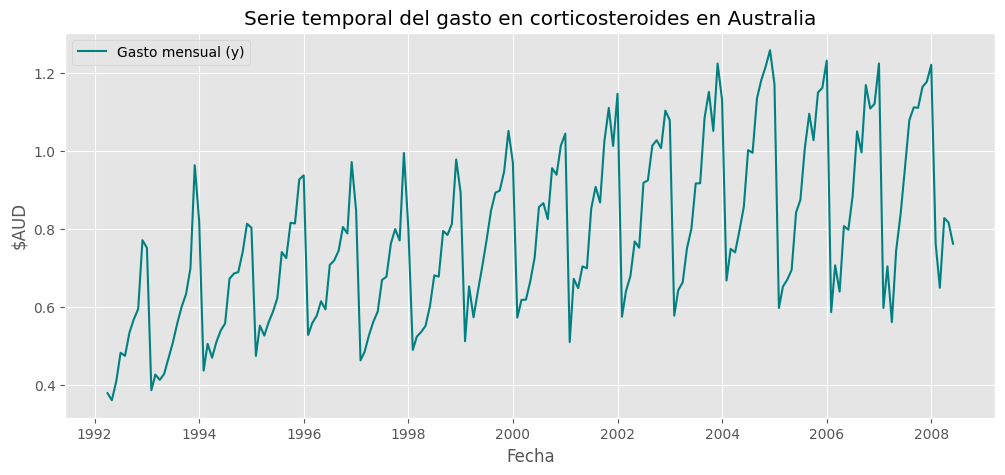

In [20]:
# Visualizamos la distribución de cada atributo
plt.figure(figsize=(12, 5))
plt.plot(h2o.index, h2o['y'], label='Gasto mensual (y)', color='teal')
plt.title('Serie temporal del gasto en corticosteroides en Australia')
plt.ylabel('$AUD')
plt.xlabel('Fecha')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
#Verificación de valores faltantes
# Comprobamos si hay valores nulos en los datos
h2o.isnull().sum()

# No se encuentran valores nulos, así que continuamos

y         0
exog_1    0
exog_2    0
dtype: int64

## **3. Descomposición de la serie**

Separación de la serie en tendencia, estacionalidad y residuo.

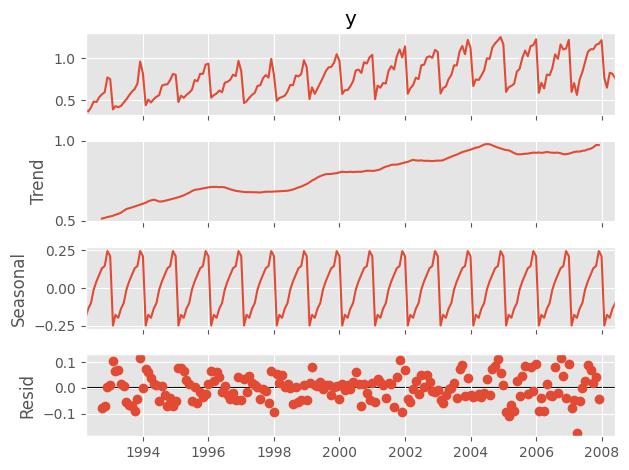

In [25]:
# Descomponemos la serie temporal para identificar la tendencia, estacionalidad y residuos
result = seasonal_decompose(h2o['y'], model='additive', period=12)
result.plot()
plt.show()

## **4. Prueba de estacionariedad**
Aplicación de la prueba de Dickey-Fuller y visualización de ACF/PACF.

Se aplica la prueba de Dickey-Fuller aumentada (ADF) para verificar si la serie temporal es estacionaria.  
 Los modelos ARIMA y SARIMA requieren que los datos sean estacionarios para ofrecer resultados válidos.

In [27]:
# Realizamos la prueba de Dickey-Fuller para comprobar si la serie es estacionaria

adf_result = adfuller(h2o['y'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-Value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie NO es estacionaria.")


ADF Statistic: -1.5180458060933528
P-Value: 0.5245662008648627
La serie NO es estacionaria.


En este caso, el p-valor fue **0.52**, por lo tanto, **la serie NO es estacionaria**.

## **5. Transformación de la serie no estacionaria**

Se aplica una primera diferencia (`.diff()`) para eliminar tendencias y lograr estacionariedad.  

In [31]:
# transformación de una serie no estacionaria
h2o['y_diff'] = h2o['y'].diff()
h2o.dropna(inplace=True)

In [35]:
adf_result_diff = adfuller(h2o['y_diff'])
print(f"ADF (diferenciada): {adf_result_diff[0]:.4f}, p-value: {adf_result_diff[1]:.4f}")

ADF (diferenciada): -3.2725, p-value: 0.0162


Al transformar la serie en estacionaria (p-valor ADF tras la diferencia = **0.0162**), ya podemos usarla en un modelo SARIMA con `d=1`.

## **6. ACF y PACF para ver autocorrelaciones**

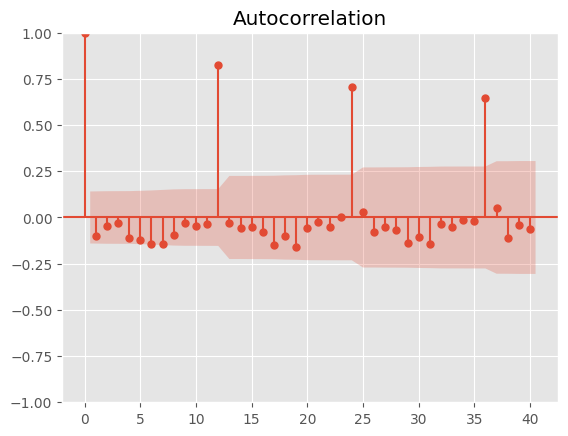

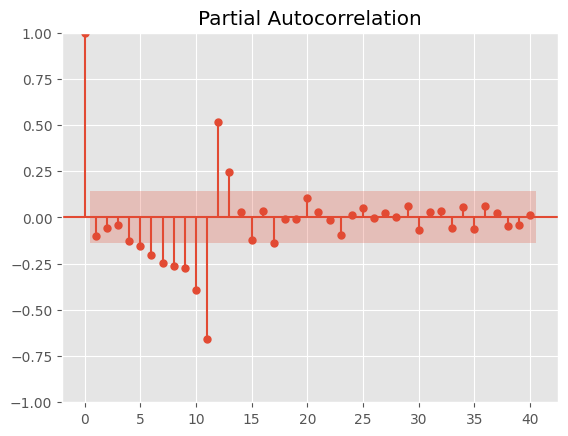

In [40]:
plot_acf(h2o['y_diff'], lags=40)
plt.show()
plot_pacf(h2o['y_diff'], lags=40)
plt.show()

## **7. Modelo ARIMA/SARIMAX con variables exógenas**

Se define un modelo SARIMAX con:
- Orden no estacional: (p,d,q) = (1,1,1)
- Orden estacional: (P,D,Q,s) = (1,1,1,12)
- Variables exógenas: `exog_1`, `exog_2`  

Este modelo capta tanto patrones estacionales (mensuales/anuales) como influencias externas que pueden mejorar las predicciones.

In [43]:
# separación de entrenamiento y prueba
train = h2o.iloc[:-12]
test = h2o.iloc[-12:]

# Aplicación del modelo SARIMA
# Entrenamiento simple con exógenas
model = SARIMAX(h2o['y'], 
               exog=h2o[['exog_1', 'exog_2']],
               order=(1, 1, 1),
               seasonal_order=(1, 1, 1, 12))

model_fit = model.fit(disp=False)
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  194
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 296.888
Date:                            Mon, 16 Jun 2025   AIC                           -579.776
Time:                                    12:31:23   BIC                           -557.387
Sample:                                05-01-1992   HQIC                          -570.699
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog_1        -0.2966      0.191     -1.552      0.121      -0.671       0.078
exog_2         1.1839      0.209   

Se entrena el modelo con `fit()`, estimando los parámetros automáticamente.  
Para obtener los coeficientes del modelo y poder usarlo en análisis y predicción.

Se revisan las métricas del modelo (`summary()`), incluyendo:
- Coeficientes y su significancia (p-valores)
- AIC/BIC (criterios de ajuste)
- RMSE (error medio cuadrático)

En este caso, el modelo tiene un **RMSE de 0.03** y un **AIC de -579.77**, lo cual indica un buen ajuste.

## **8. Validación y predicción**

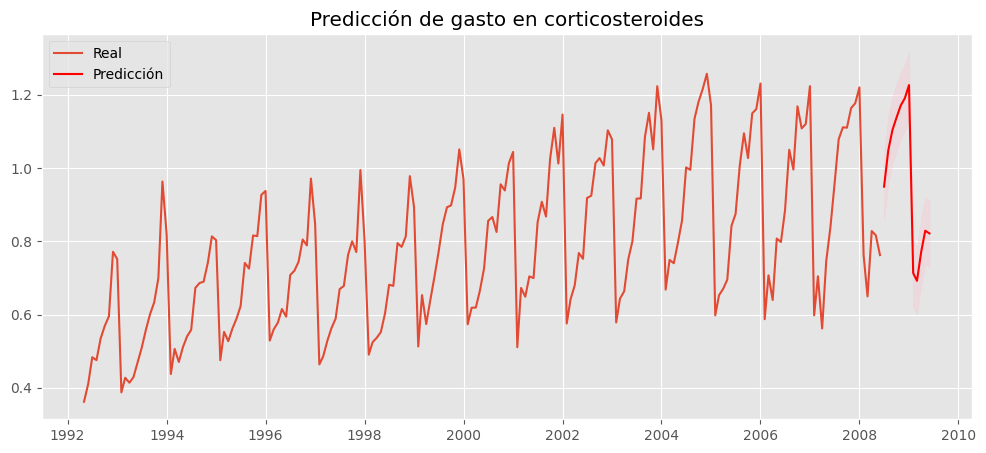

RMSE: 0.03


In [45]:
# Predicción y evaluación
forecast = model_fit.get_forecast(steps=12, exog=test[['exog_1', 'exog_2']])
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot de predicción
plt.figure(figsize=(12, 5))
plt.plot(h2o.index, h2o['y'], label='Real')
plt.plot(pred_mean.index, pred_mean, color='red', label='Predicción')
plt.fill_between(pred_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Predicción de gasto en corticosteroides')
plt.show()

rmse = mean_squared_error(test['y'], pred_mean, squared=False)
print(f"RMSE: {rmse:.2f}")



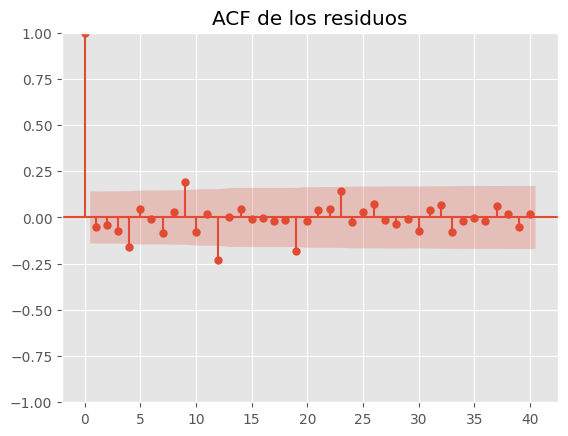

In [48]:
# Análisis de residuos
residuals = model_fit.resid
plot_acf(residuals.dropna(), lags=40)
plt.title("ACF de los residuos")
plt.show()

Se realizan pruebas de diagnóstico sobre los residuos:
- **Ljung-Box**: no hay autocorrelación (p=0.97)
- **Jarque-Bera**: residuos aproximadamente normales (p=0.15)
- **Heterocedasticidad**: detectada (p=0.00)

Estas pruebas aseguran que el modelo cumple con los supuestos estadísticos requeridos. Si los residuos tienen patrones, el modelo puede mejorarse.

## **9. Conclusiones**

**Estacionalidad y estacionariedad**

- La serie original no es estacionaria, como lo confirma el test de Dickey-Fuller aumentado (ADF) con un valor estadístico de -1.518 y un p-valor de 0.52 (> 0.05).

- La serie se vuelve estacionaria tras una diferenciación, con un estadístico ADF de -3.27 y un p-valor de 0.0162 (< 0.05). Esto valida el uso de una integración de orden 1 (d=1) en el modelo SARIMA.

**Modelo SARIMAX(1, 1, 1)(1, 1, 1, 12)**

- Se ha ajustado un modelo SARIMA con estacionalidad anual (frecuencia 12), considerando dos variables exógenas (exog_1 y exog_2).

- El modelo muestra un buen ajuste:
  - Log-Likelihood: 296.89
  - AIC: -579.78
  - RMSE: 0.03 (muy bajo, lo cual indica buen desempeño)

**Evaluación de los coeficientes**

- exog_1: No significativa (p = 0.121). Puede evaluarse su exclusión en futuras iteraciones del modelo.

- exog_2: Altamente significativa (p < 0.001), con fuerte influencia positiva sobre la variable dependiente.

- Componentes AR y MA (no estacionales):
  - AR(1): marginalmente significativo (p ≈ 0.08)
  -  MA(1): muy significativo (p < 0.001)

- Componentes estacionales:
  - AR(12): no significativo (p = 0.446)
  - MA(12): significativo (p < 0.001)

**Diagnóstico del modelo**
- Ljung-Box Test (L1): p = 0.97 → no hay autocorrelación significativa en los residuos (lo cual es deseable).
- Jarque-Bera Test: p = 0.15 → los residuos no se desvían significativamente de una distribución normal.
- Heterocedasticidad (H = 2.28, p ≈ 0.00): hay evidencia de heterocedasticidad. Se podría considerar aplicar un modelo más robusto si es relevante para el problema (como un SARIMAX con varianza condicional tipo GARCH, o aplicar transformaciones previas).

